# [음성 분류 경진대회](https://dacon.io/competitions/official/235905/overview/description)
- 데이터 분석 참고: https://dacon.io/competitions/official/235905/codeshare/5153

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/data')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import librosa
import librosa.display as dsp
from IPython.display import Audio

import tensorflow as tf

In [ ]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(929)

## 데이터 불러오기

In [ ]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
train.head()

,file_name,label
0,001.wav,9
1,002.wav,0
2,004.wav,1
3,005.wav,8
4,006.wav,0


### Sampling rate
- sampling rate는 아날로그 정보를 얼마나 잘게 쪼갤지를 결정
- 잘게 쪼갤수록 정보 손실이 줄어들지만, 데이터의 크기는 증가
- 일반적으로 인간의 청각영역은 8 kHz(8000 sample/second)이며,   
  sampleing rate는 2배 커져 16000으로 설정 (librosa에서의 기본값은 22050)
- 하지만 더 나은 해상도를 위해 좀 더 여유롭게 20000으로 설정

In [ ]:
sr = 20000

데이터마다 모두 다른 길이를 가지고 있음을 확인

In [ ]:
for i in os.listdir('./train')[:3]:
    print(f'{i}')
    data, sample_rate = librosa.load(f'./train/{i}', sr=sr)
    print('sample rate:', sample_rate, ', audio shape:', data.shape)
    print('length:', data.shape[0]/float(sample_rate), 'secs')
    print('='*42)

249.wav
sample rate: 20000 , audio shape: (11267,)
length: 0.56335 secs
513.wav
sample rate: 20000 , audio shape: (12640,)
length: 0.632 secs
507.wav
sample rate: 20000 , audio shape: (12845,)
length: 0.64225 secs


In [ ]:
target = np.array(train.label)

def load_audio(file_names, path):
    audios = list()
    for file in file_names:
        audio, _ = librosa.load(path+file, sr=sr)
        audios.append(np.array(audio))
    return np.array(audios)

train_audio = load_audio(train.file_name,'data/train/')
test_audio = load_audio(test.file_name,'data/test/')

print(train_audio.shape, target.shape, test_audio.shape)

(400,) (400,) (200,)


## 데이터 전처리
### 1) Mel Spectrogram
- 사람은 낮은 주파수를 높은 주파수보다 더 예민하게 받아들임
- 500 ~ 1500 Hz 가 바뀌는건 예민하게 인식하는데 반해 10000Hz ~ 11000Hz가 바뀌는 것은 잘 인식하지 못함
- 주파수 단위를 해당 공식 $m = 2595 \log_{10}\left(1 + \frac{f}{700}\right)$ 에 따라 멜 스케일로 변환
- 해당 scale을 적용해 spectogram을 만든 것이 melspectogram

### 2) MFCC
- Mel-Spectrogram이라는 피쳐에 대해 행렬을 압축해서 표현해주는 DCT 연산을 수행

### 3) Mel Spectrogram vs MFCC
- Mel Spectrogram의 경우 주파수끼리 Correlate하기 때문에 도메인이 한정적인 문제에서 더 좋은 성능을 보이고,
- MFCC의 경우는 De-Correlate를 해주기 때문에 일반적인 상황에서 더 좋은 성능을 보여줌

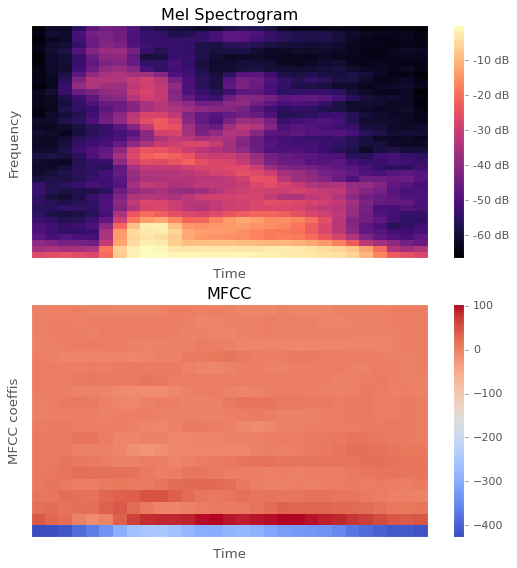

In [ ]:
idx = 15
mels = librosa.feature.melspectrogram(train_audio[idx], sr=sr, n_mels=40)
log_mels = librosa.power_to_db(mels, ref=np.max)
mfcc = librosa.feature.mfcc(train_audio[idx], sr=sr, n_mels=40)

plt.style.use('ggplot')
fig, ax = plt.subplots(2, 1, figsize=(8,8))

mels_img = librosa.display.specshow(log_mels, sr=sr, ax=ax[0])
ax[0].set(title='Mel Spectrogram', xlabel='Time', ylabel='Frequency')
fig.colorbar(mels_img, ax=ax[0], format='%+2.0f dB')

mfcc_img = librosa.display.specshow(mfcc, sr=sr, ax=ax[1])
ax[1].set(title='MFCC', xlabel='Time', ylabel='MFCC coeffis')
fig.colorbar(mfcc_img, ax=ax[1])

plt.show()

### 4) Padding
- 오디오들의 길이가 같지 않기때문에 melspectrogram과 mfcc 모두 길이가 제각각
- 여유로운 크기의 고정 사이즈를 정하고 고정사이즈에 맞추어 랜덤으로 앞이나 뒤에 padding을 실시
- 각각 파일마다 데시벨의 차이가 있을 것이라 생각하고 파일마다 min_max_scale 실시
- padding이전에 scale할것인가 이후에 할 것인가는 각 featureset의 아웃풋 이미지를보고 색이 적절한 것을 선택

#### translation invariance
- CNN에서 translation invariance란 input의 위치가 달라져도 output이 동일한 값을 갖는것
- 분류에 cnn모델을 적용할 것이기 때문에 padding 적용가능

In [ ]:
def random_pad(mels, pad_size, mfcc=True):
    pad_width = pad_size - mels.shape[1]
    rand = np.random.rand()
    left = int(pad_width * rand)
    right = pad_width - left
    
    if mfcc:
        mels = np.pad(mels, pad_width=((0,0), (left, right)), mode='constant')
        local_max, local_min = mels.max(), mels.min()
        mels = (mels - local_min)/(local_max - local_min)
    else:
        local_max, local_min = mels.max(), mels.min()
        mels = (mels - local_min)/(local_max - local_min)
        mels = np.pad(mels, pad_width=((0,0), (left, right)), mode='constant')

    return mels

- 가장 긴 파일의 오디오정보가 잘리지 않을 정도의 pad_size를 설정
- 즉, pad_size는 sample rate에 따라 달라질 것
- melspectrogram과 mfcc의 n은 리턴값이 정사각형이 될 수 있도록 같은 40 설정 
- 리턴값이 커질수록 feature의 값이 많아지는 것이기 때문에 성능에 영향을 미칠 것으로 예상

In [ ]:
size = 40
pad_size = 40
repeat_size = 5

- train에는 data agumentation이 될 것이라고 생각하고 하나의 파일에 5번 padding을 이용해 생성 

In [ ]:
mels_audio = list()
mfcc_audio = list()

for y in train_audio:
    mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=size)
    mels = librosa.power_to_db(mels, ref=np.max)
    mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=size)

    for i in range(repeat_size):
        mels_audio.append(random_pad(mels, pad_size=pad_size, mfcc=False))
        mfcc_audio.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))

In [ ]:
mels_test = list()
mfcc_test = list()

for y in test_audio:
    mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=size)
    mels = librosa.power_to_db(mels, ref=np.max)
    mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=size)

    mels_test.append(random_pad(mels, pad_size=pad_size, mfcc=False))
    mfcc_test.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))

- librosa로 리턴된값은 바로 모델에 들어갈 수 없기 때문에 np.array로 변환
- 각각 melspectrogram, mfcc 데이터 셋이 생성됨

In [ ]:
train_mels = np.array(mels_audio, np.float64)
train_mfcc = np.array(mfcc_audio, np.float64)

test_mels = np.array(mels_test, np.float64)
train_mfcc = np.array(mfcc_test, np.float64)

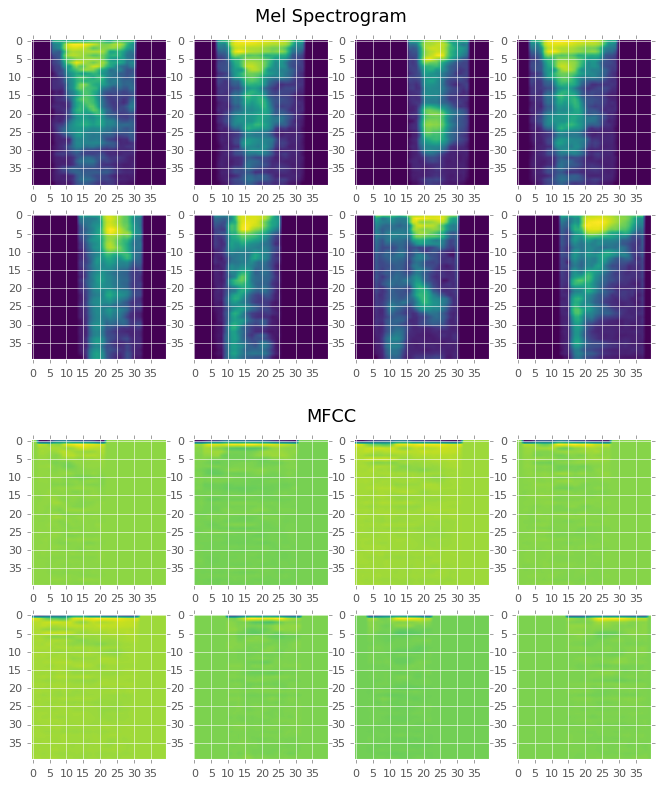

In [ ]:
index = np.where(target==2)[0]
index = np.random.choice(index,16)

fig = plt.figure(figsize=(10,10))
subfigs = fig.subfigures(2, 1)
subfigs[0].suptitle('Mel Spectrogram', fontsize=16)
subfigs[1].suptitle('MFCC', fontsize=16)

axs_top = subfigs[0].subplots(2,4)
axs_bot = subfigs[1].subplots(2,4)

for i, idx in enumerate(index):
    if i < 8:
        axs_top[i//4,i%4].imshow(train_mels[idx], aspect='auto', cmap='viridis')
    else:
        axs_bot[(i-8)//4,(i-8)%4].imshow(train_mfcc[idx], aspect='auto', cmap='viridis')
plt.show()

- 증강한 데이터만큼 target값도 복제

In [ ]:
repeated_target = np.repeat(target, repeat_size)

## Model
- pre-trained 모델 사용이 불가능
- audio분야에서 많이 사용된다는 Resnet의 ResBlock을 응용하여 작은 모델 생성
- audio 학습에 대한 체험이 목적이기에 modeling에 큰 힘을 쏟지 않음
- 타모델들을 같이 사용하여 emsenble 한다면 성능 향상 예상

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, MaxPool2D, ZeroPadding2D, BatchNormalization, Input, DepthwiseConv2D, Add, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
def residual_block(x, filters_in, filters_out):
    shortcut = x
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters_in, kernel_size=(1, 1), strides=(1, 1), padding="same",kernel_initializer='he_normal')(x)

    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = Conv2D(filters_in, kernel_size=(3, 3), strides=(1, 1), padding="same",kernel_initializer='he_normal')(x)

    x = BatchNormalization()(x)
    x = ReLU()(x)  
    x = Conv2D(filters_out, kernel_size=(1, 1), strides=(1, 1), padding="same",kernel_initializer='he_normal')(x)

    shortcut_channel = x.shape.as_list()[0]
    
    if shortcut_channel != filters_out:
        shortcut = Conv2D(filters_out, kernel_size=(1, 1), strides=(1, 1), padding="same",kernel_initializer='he_normal')(shortcut)
        
    x = Add()([x, shortcut])
    return ReLU()(x)

In [ ]:
def build_model():
    inputs = tf.keras.layers.Input(shape=(size,pad_size,1))

    outputs = Conv2D(16,(3,3),activation=None,padding='same',kernel_initializer='he_normal')(inputs)
    outputs = BatchNormalization()(outputs)
    outputs = ReLU()(outputs)
    outputs = MaxPool2D((2,2))(outputs)

    outputs = residual_block(outputs, 16, 32)
    outputs = MaxPool2D((2,2))(outputs)
    outputs = residual_block(outputs, 32, 32)
    # outputs = residual_block(outputs, 32, 32)
    outputs = residual_block(outputs, 32, 64)
    outputs = MaxPool2D((2,2))(outputs)
    outputs = residual_block(outputs, 64, 64)
    # outputs = residual_block(outputs, 64, 64)
    # outputs = MaxPool2D((2,2))(outputs)

    outputs = GlobalAveragePooling2D()(outputs)
    # outputs = Flatten()(outputs)

    outputs = Dense(32,activation=None,kernel_initializer='he_normal')(outputs)
    outputs = BatchNormalization()(outputs)
    outputs = ReLU()(outputs)
    outputs = Dropout(0.5)(outputs)

    outputs = Dense(10,activation='softmax')(outputs)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    return model

# model = build_model()
# model.summary()

## Model Fitting
- 5-fold StratifiedKFold 실시 및
- 같은 모델을 melspectrogram, mfcc featureset에 학습시켜 emsenble

In [ ]:
from tensorflow.keras.models import load_model

def fit_model(train, target, train_idx, val_idx, filepath):
    model = build_model()
    x_train, x_val, y_train, y_val = train[train_idx], train[val_idx], target[train_idx], target[val_idx]
    callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')]
    history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val,y_val), callbacks=callbacks, verbose=0)
    return load_model(filepath)

In [ ]:
def pred_label(model, val, target, val_idx, test, name):
    x_val, y_val = val[val_idx], target[val_idx]
    preds_val = model.predict(x_val)
    pred_val = np.argmax(preds_val, axis=1)
    print(f'{name}_acc: {accuracy_score(y_val,pred_val):.4f}')
    preds = model.predict(test)
    return preds_val, preds

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from datetime import datetime

acc_list = []
pred_list = []
skf = StratifiedKFold(n_splits=5)

if not os.path.exists('./model'):
    os.mkdir('./model')
model_root = os.path.join('./model', datetime.now().strftime('%Y%m%d_%H:%M:%S'))
os.mkdir(model_root)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_mels, repeated_target)):
    print(f'\n********** {fold+1} fold **********')
    preds_vals = []

    ### melspectrogram ###
    filepath = os.path.join(model_root, f'res_mels_{fold}.hdf5')
    model = fit_model(train_mels, repeated_target, train_idx, val_idx, filepath)
    preds_val, preds = pred_label(model, train_mels, repeated_target, val_idx, test_mels, 'mels')
    preds_vals.append(preds_val)
    pred_list.append(preds)

    ### mfcc ###
    filepath = os.path.join(model_root, f'res_mfcc_{fold}.hdf5')
    model = fit_model(train_mfcc, repeated_target, train_idx, val_idx, filepath)
    preds_val, preds = pred_label(model, train_mfcc, repeated_target, val_idx, test_mels, 'mels')
    preds_vals.append(preds_val)
    pred_list.append(preds)

    ### ensemble ###
    pred = np.argmax(sum(preds_vals), axis=1)
    en_acc = accuracy_score(repeated_target[val_idx],pred)
    acc_list.append(en_acc)
    print(f'ensemble_acc : {en_acc:.4f}')

print(f'\n\nmean_acc : {np.mean(acc_list):.4f}')


********** 1 fold **********
mels_acc : 0.9750
mfcc_acc : 0.9625
ensemble_acc : 0.9875

********** 2 fold **********
mels_acc : 0.9700
mfcc_acc : 0.9275
ensemble_acc : 0.9625

********** 3 fold **********
mels_acc : 0.9800
mfcc_acc : 0.9575
ensemble_acc : 0.9875

********** 4 fold **********
mels_acc : 0.9650
mfcc_acc : 0.9125
ensemble_acc : 0.9800

********** 5 fold **********
mels_acc : 0.9650
mfcc_acc : 0.9150
ensemble_acc : 0.9450


mean_acc : 0.9725


- 한개의 featureset을 이용한 것 보다 ensemble이 더 나은 성능들을 보임

In [ ]:
submission['label'] = np.argmax(sum(pred_list), axis=1)
submission.head()

,file_name,label
0,003.wav,0
1,008.wav,9
2,010.wav,3
3,015.wav,8
4,024.wav,2


In [ ]:
submission.to_csv('mels_mfcc.csv', index=False)